<a href="https://colab.research.google.com/github/sumankanukollu/EVA_4_Assignments/blob/master/EVA4S6_suman_code5_LRScheduler_L1_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from IPython.core.debugger import set_trace

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-4.0, 4.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

"""# Dataset and Creating Train/Test Split"""

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)



Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        drpout = nn.Dropout(0.16)

        self.layer1 = nn.Sequential(
            nn.Conv2d(1,8,3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            #drpout
        )# OP-26   RF-3
        self.layer2 = nn.Sequential(
            nn.Conv2d(8,16,3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            drpout
        ) # OP-24  RF-5
        self.layer3_MP= nn.MaxPool2d(2,2) #OP-12  RF-6
        self.layer4 = nn.Sequential(		
            nn.Conv2d(16,8,3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            #drpout
        ) # OP-10	RF-10
        
        self.layer5 = nn.Sequential(		
            nn.Conv2d(8,16,3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #drpout
        ) # OP-8  RF-14
        self.layer6 = nn.Sequential(
            nn.Conv2d(16,16,3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #drpout
        ) # OP-6  RF-18
        self.layer7 = nn.Sequential(
            nn.Conv2d(16,16,3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            drpout
        ) #op-4 RF-22

        self.layer8 = nn.Sequential(
            nn.Conv2d(16,10,1,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
            #drpout
        ) #op-4 RF-22
        self.gap = nn.Sequential(
           nn.AvgPool2d(kernel_size=4)
        )
        '''
        self.layer9 = nn.Sequential(
            # Last-1 layer
            nn.Conv2d(10,10,4,bias=False)
            #nn.ReLU()
        )#op-1 RF-28'''

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3_MP(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.gap(x)
        #x = self.layer9(x)


        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 10, 10]           1,152
             ReLU-11            [-1, 8, 10, 10]               0
      BatchNorm2d-12            [-1, 8, 10, 10]              16
           Conv2d-13             [-1, 16, 8, 8]           1,152
             ReLU-14             [-1, 1

In [0]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(train_loader,model,device,optimizer,epoch):
    # sets te module in training mode
    model.train()
    pbar = tqdm(train_loader)  
    correct,processed = 0,0
    for batch_idx, (data,target) in enumerate(pbar):
      data, target = data.to(device), target.to(device)
      y_pred      = model(data)
      loss_score  = F.nll_loss(y_pred,target)
      ####### L1 + L2  regularization
      lambda1, lambda2 = 0.5, 0.01
      # L1 regularization
      for param in model.parameters():
        l1_regularization = lambda1*torch.sum(abs(param))

      # L2 regularization
      for param in model.parameters():
        l2_regularization = lambda2* torch.sum(torch.pow(param, 2))

      loss = loss_score + l1_regularization + l2_regularization
      ###########
      train_losses.append(loss_score)
      optimizer.zero_grad()
      loss_score.backward()
      optimizer.step()

      # update pbar-tqdm
      ##### get the index of the max log-probability
      pred = y_pred.argmax(dim=1,keepdim = True)
      correct = correct + pred.eq(target.view_as(pred)).sum().item()
      processed = processed + len(data)
      
      pbar.set_description(desc= f'Loss={loss_score.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      train_acc.append(100*correct/processed)


def display_prediction(example_data,example_targets):
    fig = plt.figure()
    for i in range(6):
      plt.subplot(2,3,i+1)
      plt.tight_layout()
      #set_trace()
      plt.imshow(example_data[i][0].cpu().data.numpy(), cmap='gray', interpolation='none')
      plt.title("Predicted: {}".format(example_targets[i]))
      plt.xticks([])
      plt.yticks([])
    fig


def test(test_loader,model,device):
      # set the module in evaluation mode
      model.eval()
      #set_trace()
      test_loss,correct = 0,0
      with torch.no_grad():
        for data,target in test_loader:
          data,target  = data.to(device),target.to(device)
          #set_trace()
          #display_prediction(data,target)
          test_output  = model(data)
          test_loss    = test_loss + F.nll_loss(test_output,target,reduction='sum').item()
          pred = test_output.argmax(dim=1,keepdim=True)
          correct = correct + pred.eq(target.view_as(pred)).sum().item()
      test_loss = test_loss/len(test_loader.dataset)
      test_losses.append(test_loss)

      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        
      test_acc.append(100. * correct / len(test_loader.dataset))



In [0]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.005)
EPOCHS = 40
for epoch in range(1,EPOCHS+1):
    print("EPOCH:", epoch)
    train(train_loader, model, device, optimizer, epoch)
    test(test_loader,model, device)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.1384803205728531 Batch_id=468 Accuracy=93.78: 100%|██████████| 469/469 [00:14<00:00, 32.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0940, Accuracy: 9837/10000 (98.37%)

EPOCH: 2


Loss=0.06628359109163284 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0955, Accuracy: 9768/10000 (97.68%)

EPOCH: 3


Loss=0.10199075937271118 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0565, Accuracy: 9855/10000 (98.55%)

EPOCH: 4


Loss=0.038321640342473984 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9872/10000 (98.72%)

EPOCH: 5


Loss=0.014245323836803436 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9909/10000 (99.09%)

EPOCH: 6


Loss=0.030130626633763313 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 33.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Loss=0.032990697771310806 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 33.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9891/10000 (98.91%)

EPOCH: 8


Loss=0.0349968783557415 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 33.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9904/10000 (99.04%)

EPOCH: 9


Loss=0.04708581790328026 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:14<00:00, 33.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9919/10000 (99.19%)

EPOCH: 10


Loss=0.017578249797225 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.14027662575244904 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 41.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.06445879489183426 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 33.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.008942194283008575 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 34.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


Loss=0.019392138347029686 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 34.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9913/10000 (99.13%)

EPOCH: 15


Loss=0.015964461490511894 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 33.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.00645928829908371 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:13<00:00, 34.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

EPOCH: 17


Loss=0.04630202427506447 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:14<00:00, 32.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.04552347585558891 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:13<00:00, 34.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.0707491859793663 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9933/10000 (99.33%)

EPOCH: 20


Loss=0.016826311126351357 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9929/10000 (99.29%)

EPOCH: 21


Loss=0.009971623308956623 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9930/10000 (99.30%)

EPOCH: 22


Loss=0.005877444986253977 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:13<00:00, 34.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9929/10000 (99.29%)

EPOCH: 23


Loss=0.00873104203492403 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9936/10000 (99.36%)

EPOCH: 24


Loss=0.006336385849863291 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:14<00:00, 33.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9931/10000 (99.31%)

EPOCH: 25


Loss=0.021928539499640465 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:13<00:00, 41.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9927/10000 (99.27%)

EPOCH: 26


Loss=0.015340179204940796 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:13<00:00, 35.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9930/10000 (99.30%)

EPOCH: 27


Loss=0.026385396718978882 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:13<00:00, 34.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9948/10000 (99.48%)

EPOCH: 28


Loss=0.04710093513131142 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:13<00:00, 33.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9930/10000 (99.30%)

EPOCH: 29


Loss=0.003969376441091299 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:13<00:00, 33.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9936/10000 (99.36%)

EPOCH: 30


Loss=0.017842009663581848 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:13<00:00, 34.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9934/10000 (99.34%)

EPOCH: 31


Loss=0.02663787640631199 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:13<00:00, 35.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9933/10000 (99.33%)

EPOCH: 32


Loss=0.006655551493167877 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

EPOCH: 33


Loss=0.01836731843650341 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:13<00:00, 42.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9943/10000 (99.43%)

EPOCH: 34


Loss=0.009706671349704266 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:13<00:00, 35.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9935/10000 (99.35%)

EPOCH: 35


Loss=0.0031759340781718493 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:13<00:00, 34.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9924/10000 (99.24%)

EPOCH: 36


Loss=0.014853273518383503 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9930/10000 (99.30%)

EPOCH: 37


Loss=0.003457486629486084 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:13<00:00, 33.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9942/10000 (99.42%)

EPOCH: 38


Loss=0.009044934995472431 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9933/10000 (99.33%)

EPOCH: 39


Loss=0.003432656405493617 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:13<00:00, 35.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

EPOCH: 40


Loss=0.012586082331836224 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]



Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)



Text(0.5, 1.0, 'Test Accuracy')

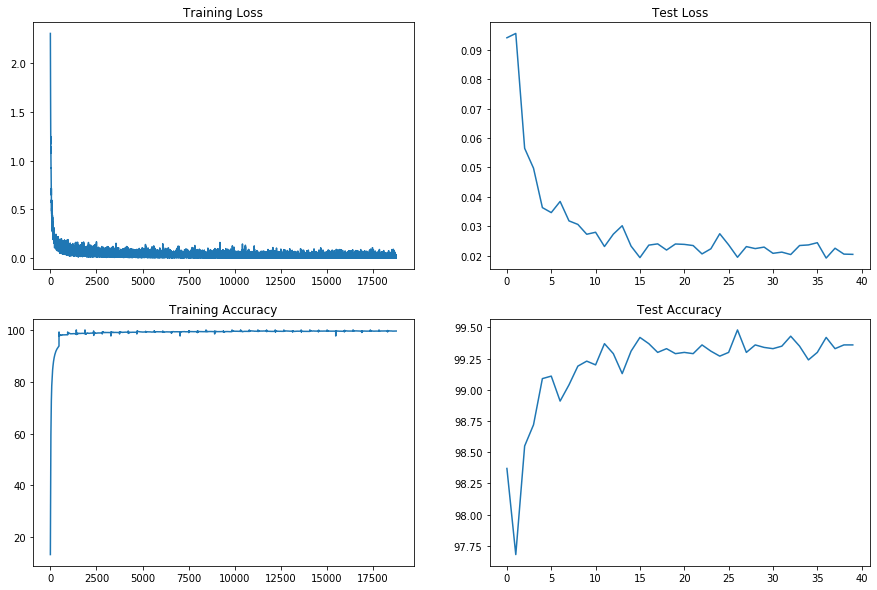

In [0]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


Images are : torch.Size([25, 1, 28, 28])
labels are : tensor([5, 3, 9, 8, 0, 1, 2, 7, 7, 6, 3, 3, 0, 1, 9, 3, 3, 6, 1, 7, 9, 7, 2, 6,
        0])
Pred : 0 - zero:False
Pred : 0 - zero:False
Pred : 0 - zero:False
Pred : 0 - zero:False
Pred : 0 - zero:True
Pred : 0 - zero:False
Pred : 0 - zero:False
Pred : 0 - zero:False
Pred : 0 - zero:False
Pred : 8 - eight:False
Pred : 0 - zero:False
Pred : 0 - zero:False
Pred : 0 - zero:True
Pred : 0 - zero:False
Pred : 0 - zero:False
Pred : 0 - zero:False
Pred : 0 - zero:False
Pred : 0 - zero:False
Pred : 0 - zero:False
Pred : 0 - zero:False
Pred : 0 - zero:False
Pred : 0 - zero:False
Pred : 0 - zero:False
Pred : 0 - zero:False
Pred : 0 - zero:True


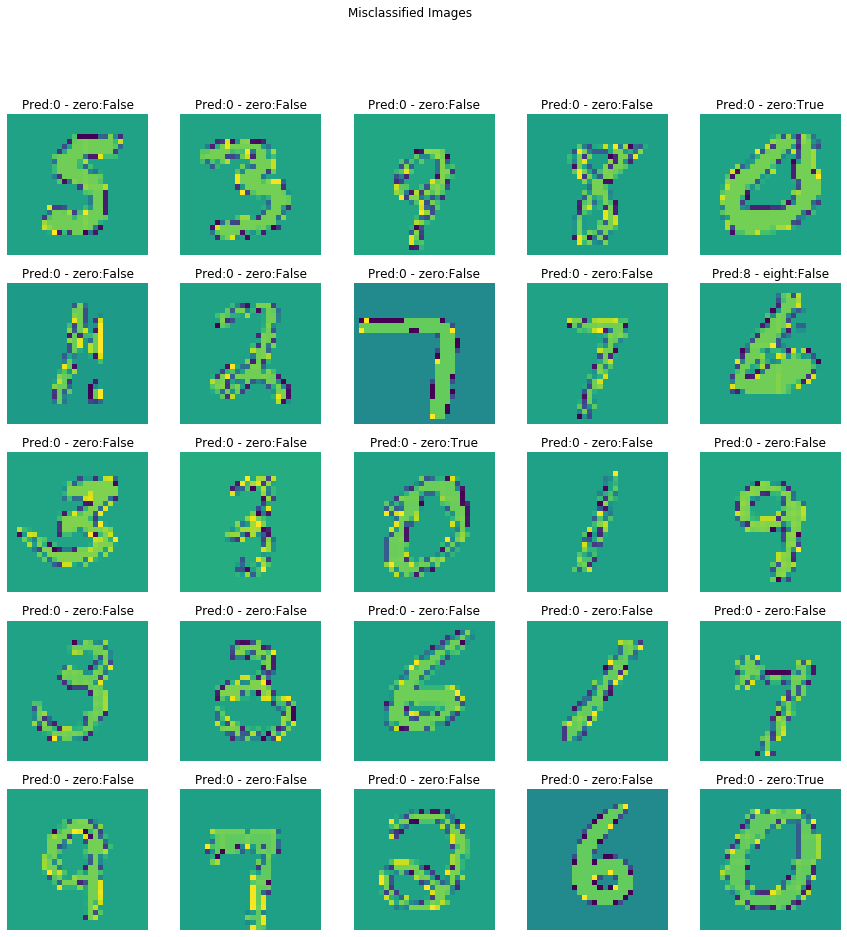

In [0]:
import numpy as np
from torch.autograd import Variable
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    #set_trace()
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

def get_random_images(num):
    data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
    
    global classes
    classes = data.classes
    print(classes)
    #set_trace()
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

def row(r):
	for i in range(0,r):
		yield i
		
def col(c):
	for i in range(c):
		yield i
		
def plotImage(image):
	to_pil = transforms.ToPILImage()
	

to_pil = transforms.ToPILImage()
images, labels = get_random_images(25)
print('\n\nImages are : {}\nlabels are : {}'.format(images.shape,labels))

fig,ax = plt.subplots(5,5,figsize=(15,15))
fig.suptitle('Misclassified Images')
imageNo = 0
for i in row(5):
  for j in col(5):
    image = to_pil(images[imageNo])
    index = predict_image(image)
    res = int(labels[imageNo]) == index
    ax[i][j].imshow(image)
    ax[i][j].axis('off')
    print('Pred : {}:{}'.format(str(classes[index]),str(res)))
    ax[i][j].set_title('Pred:{}:{}'.format(str(classes[index]),str(res)))
    imageNo = imageNo+1